# **Key Task: Identify Mispronounced Phonemes**

**Main Idea: Use Short-Term Fourier Transform on the Recorded Speech and compare with Verified Audio for the same text**

In [39]:
import numpy as np
import scipy.io.wavfile as wav
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
# Speech 1
# files.upload()
# Speech 2
# files.upload()
# Verified
# files.upload()

In [6]:
sample_rate, signal = wav.read('variable_google.wav')
# set k1, k2 as start and end times
# signal = signal[int(k1*sample_rate):int(k2*sample_rate)]

**Pre-Emphasis**

Amplify High Frequencies to Balance the Frequency Spectrum and improve Signal-to-Noise Ratio

$y(t) = x(t) - αx(t-1)$

In [7]:
alpha = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])

**Signal into Frames**

In [9]:
frame = 0.025
stride = 0.01
frame_length = frame*sample_rate
frame_step = stride*sample_rate

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

**Hamming Window on Every Frame**

In [10]:
frames *= np.hamming(frame_length)

**Short-Time Fourier Transform**

512-FFT

In [11]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [13]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

Into Function

In [45]:
def gen_fbank(f):
  sample_rate, signal = wav.read(f)
  alpha = 0.97
  emphasized_signal = np.append(signal[0], signal[1:] - alpha * signal[:-1])
  frame = 0.025
  stride = 0.01
  frame_length = frame*sample_rate
  frame_step = stride*sample_rate
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]
  frames *= np.hamming(frame_length)
  NFFT = 512
  mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
  nfilt = 40
  low_freq_mel = 0
  high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
  mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = np.floor((NFFT + 1) * hz_points / sample_rate)

  fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
      f_m_minus = int(bin[m - 1])   # left
      f_m = int(bin[m])             # center
      f_m_plus = int(bin[m + 1])    # right

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = np.dot(pow_frames, fbank.T)
  filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
  filter_banks = 20 * np.log10(filter_banks)  # dB
  filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
  filter_banks = filter_banks[46:167]
  return filter_banks

In [46]:
veriFBanks = gen_fbank('valuable_man.wav')

Google Speech: "Variable"

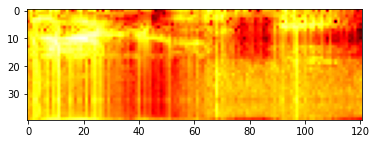

In [20]:
plt.imshow(filter_banks.T, cmap='hot')
plt.show()

Human Speech: "Valuable"

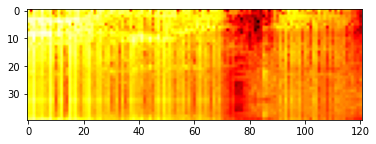

In [47]:
plt.imshow(veriFBanks.T, cmap='hot')
plt.show()

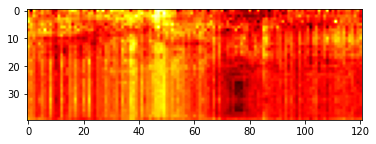

In [54]:
dist = veriFBanks.T - filter_banks.T
dist.shape

plt.imshow(dist, cmap='hot')
plt.show()

As seen in the diagram above, the heat is the difference in the Spectograms of the two audios. The hot part in the middle highlights the difference between "variable" and "valuable" - which is the "ri" and "lu" respectively